In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier 
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report

df = pd.read_csv("/kaggle/input/2022-2023-football-stats-formatted/2022-2023 Football Player Stats.csv", encoding='iso-8859-1')



df.head()






,Player,Nation,Pos,Squad,Comp,Age,Born,MP,Starts,Min,...,Fld,Off,Crs,TklW,PKwon,PKcon,Recov,AerWon,AerLost,AerWon%
0,Brenden Aaronson,USA,MFFW,Leeds United,Premier League,22,2000,20,19,1596,...,2.26,0.17,2.54,0.51,0.0,0.0,4.86,0.34,1.19,22.2
1,Yunis Abdelhamid,MAR,DF,Reims,Ligue 1,35,1987,22,22,1980,...,0.50,0.05,0.18,1.59,0.0,0.0,6.64,2.18,1.23,64.0
2,Himad Abdelli,FRA,MFFW,Angers,Ligue 1,23,1999,14,8,770,...,1.28,0.00,1.05,1.40,0.0,0.0,8.14,0.93,1.05,47.1
3,Salis Abdul Samed,GHA,MF,Lens,Ligue 1,22,2000,20,20,1799,...,1.35,0.00,0.35,0.80,0.0,0.0,6.60,0.50,0.50,50.0
4,Laurent Abergel,FRA,MF,Lorient,Ligue 1,30,1993,15,15,1165,...,1.01,0.00,0.23,2.02,0.0,0.0,6.51,0.31,0.39,44.4


# Exploratory Data Analysis 
Exploratory Data Analysis or EDA for short, is a vital aspect of machine learning tasks as it allows for developers to understand the data they are working on and the necessary steps required to make it useable by the model through identifying outliers and they data types in the dataset. This also allows for any relevant features to be identified early on in the development by looking at how they are distributed amongst the dataset and their correlations to the target variable. This section will cover the different stages of EDA, and some insights discovered through doing so.

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2689 entries, 0 to 2688
Columns: 122 entries, Player to AerWon%
dtypes: float64(111), int64(6), object(5)
memory usage: 2.5+ MB


# Information about the dataset
Before plotting graphs, the types of data being worked with must be understood. This gives an early indication for the types of data transformation and normalisation that need to be applied to the data to allow it to work with the machine learning algorithm. From the figure above it can be seen that the dataset contains 2689 individual rows of player data and 122 columns containing different metrics associated with the players. In terms of the data types there are 111 float types which are decimal numbers, 6 integer types which are whole numbers and 5 object types which are categorical values. Based off this information acquired, the categorical features will require encoding as decision trees require all features to be numerical in order to work with them. In terms of the other data types these will be checked for missing or null values during data cleaning and pre-processing.

In [3]:
df['Pos'].value_counts()

Pos
DF      825
MF      608
FW      409
FWMF    244
MFFW    208
GK      164
DFMF    101
MFDF     62
DFFW     38
FWDF     30
Name: count, dtype: int64

Defenders make up the majority of the players in the dataset followed by midfield players and finally forwards. The presence of hybrid roles can be seen with positions such as FWMF which represents players who are able to play in attacking midfield roles such as centre attacking midfielder and forward roles such as right or left wing. These hybrid roles make up significantly less of the dataset as versatile players are much rarer than players who are able to play one position effectively which explains why versatility is a sought-after trait when recruiting players. Finally, there are goalkeepers present in the dataset which need to be removed during the cleaning process as classifying goalkeepers is out of scope for this project.

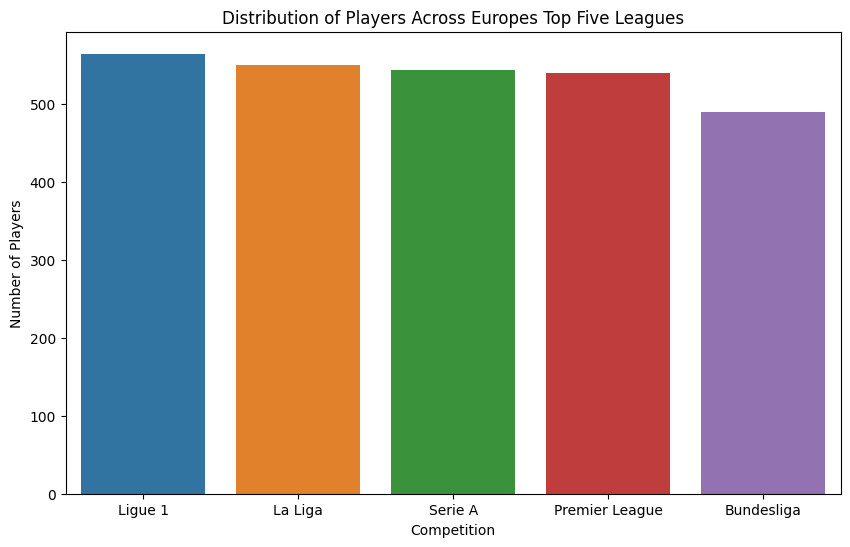

Comp
Ligue 1           21.011528
La Liga           20.453700
Serie A           20.230569
Premier League    20.081815
Bundesliga        18.222388
Name: proportion, dtype: float64


In [4]:
position_counts = df["Comp"].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=position_counts.index, y=position_counts.values)


plt.xlabel("Competition")
plt.ylabel("Number of Players")
plt.title("Distribution of Players Across Europes Top Five Leagues")



plt.show()
print(df["Comp"].value_counts(normalize=True) * 100)

# Distribution of players across europes top 5 leagues
This graph shows the number of players in each of the top five leagues across Europe. The number of players from each league is fairly equal with slightly more players coming from Ligue 1 and slightly less coming from the Bundesliga.

In [5]:
nation_counts = df['Nation'].value_counts()
top_nations = nation_counts.head(10)
print(nation_counts)


Nation
ESP    370
FRA    365
GER    230
ITA    206
ENG    184
      ... 
DOM      1
RSA      1
BDI      1
GUF      1
CTA      1
Name: count, Length: 104, dtype: int64


In [6]:
def select_countries(x):
    if x =="ESP":
        x = "Spain"
    elif x == "FRA":
        x = "France" 
    elif x == "GER":
        x = "Germany" 
    elif x == "ITA":
        x = "Italy"
    elif x == "ENG":
        x = "England"
    else:
        x = "Others"
    return x
    
df['mostCountry']  = df['Nation'].astype(str)
df['mostCountry'] = df['mostCountry'].apply(lambda x: select_countries(x))
df['mostCountry'].head()

0    Others
1    Others
2    France
3    Others
4    France
Name: mostCountry, dtype: object

<Axes: title={'center': 'Nationality'}, ylabel='count'>

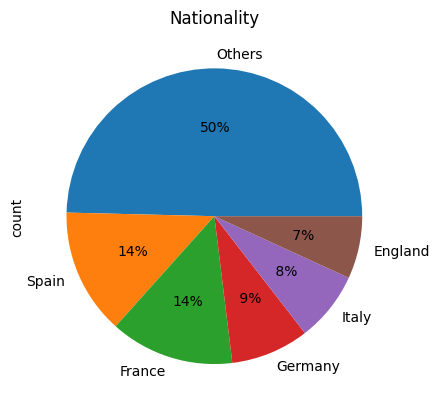

In [7]:
df['mostCountry'].value_counts().plot(kind = 'pie', title = 'Nationality', autopct='%2.0f%%')

# Different nationalities within the dataset
The pie chart shows the most prominent nationalities within the dataset. The nations with the highest number of players have been displayed and the less common nations were grouped together to form the other section of the pie chart. France and Spain were the most common nations followed by Germany however, the difference between the number of players from Germany, Italy and England was not very large.

# Relation Between Feature and Target Variable
To investigate if certain features could potentially be good predictors, a series of bar plots have been created. Although these plots will not explain how much impact a feature has on classification, they can offer clues on whether or not these features will be good indicators. For example, if successful passes are very high for midfield players compared to other positions, this may be a good predictor for midfield players. Features from all areas of the pitch have been selected to gain an early understanding of which features should be carried forward into the final implementation.

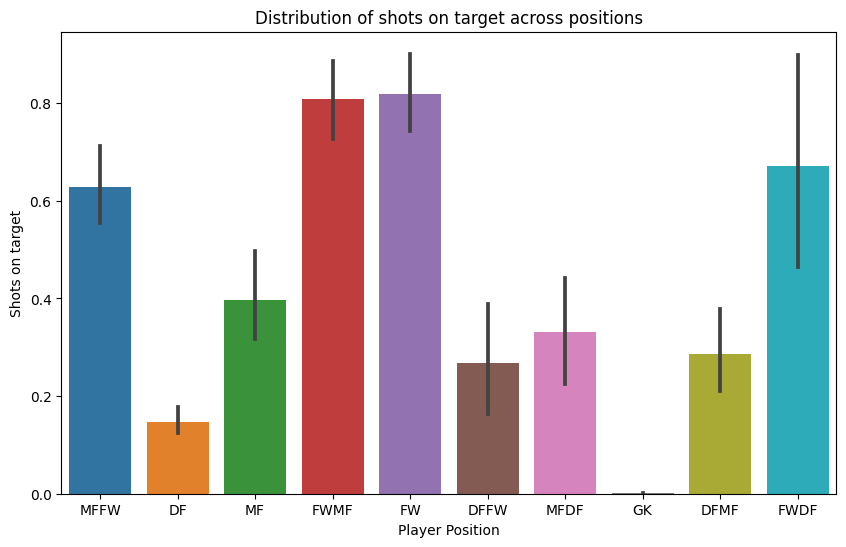

In [8]:
plt.figure(figsize=(10, 6))
sns.barplot(x=df["Pos"], y=df["SoT"])


plt.xlabel("Player Position")
plt.ylabel("Shots on target")
plt.title("Distribution of shots on target across positions")



plt.show()

When looking at shots on target, as expected, forward players record the highest values. This makes the feature a stronger predictor of player position compared to some of the other features, as there is a clear difference between positions. The error bars in this plot are noticeably larger than in other examples, suggesting greater variance among players within the forward category. This indicates that while some forwards are highly accurate shooters, others are less clinical in front of goal. As a result, shots on target can also reflect aspects of technical ability, with forwards who register fewer shots on target potentially being less effective finishers, despite occupying a role where shooting is expected.

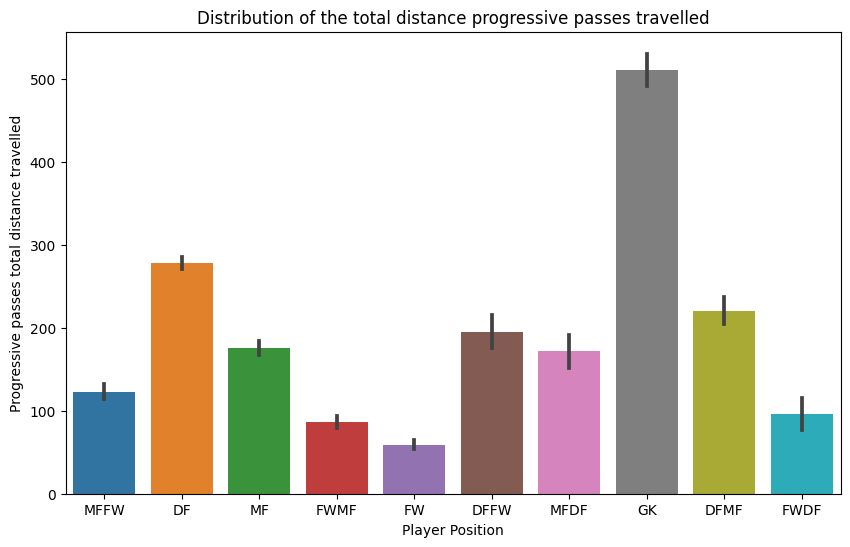

In [9]:
plt.figure(figsize=(10, 6))
sns.barplot(x=df["Pos"], y=df["PasTotPrgDist"])


plt.xlabel("Player Position")
plt.ylabel("Progressive passes total distance travelled")
plt.title("Distribution of the total distance progressive passes travelled")



plt.show()

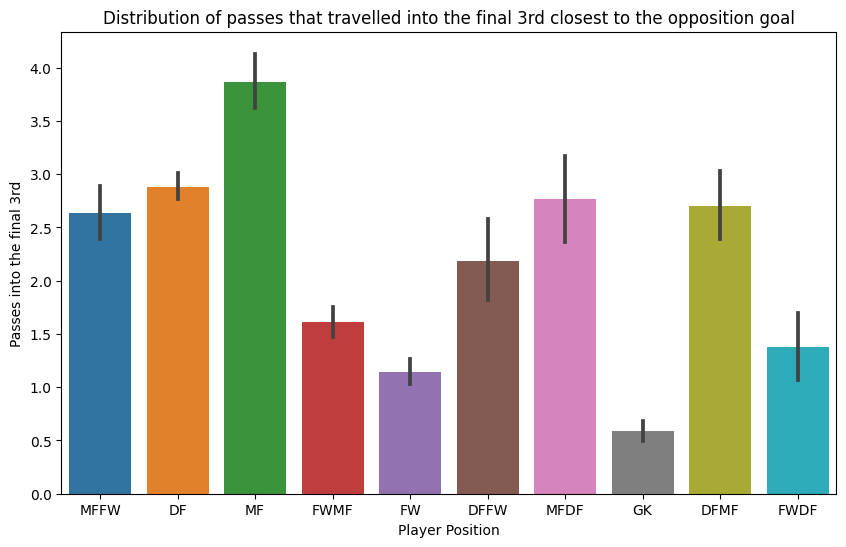

In [10]:
plt.figure(figsize=(10, 6))
sns.barplot(x=df["Pos"], y=df["Pas3rd"])


plt.xlabel("Player Position")
plt.ylabel("Passes into the final 3rd")
plt.title("Distribution of passes that travelled into the final 3rd closest to the opposition goal")



plt.show()

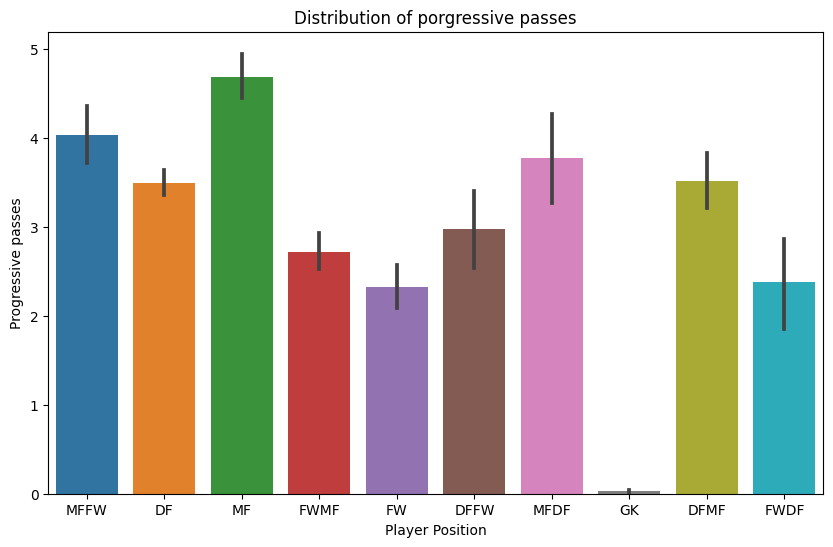

In [11]:
plt.figure(figsize=(10, 6))
sns.barplot(x=df["Pos"], y=df["PasProg"])


plt.xlabel("Player Position")
plt.ylabel("Progressive passes")
plt.title("Distribution of porgressive passes")



plt.show()

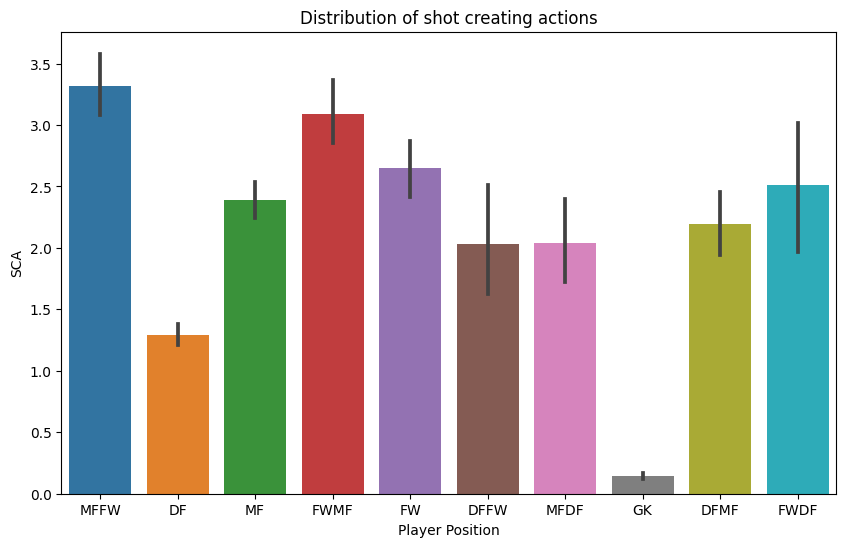

In [12]:
plt.figure(figsize=(10, 6))
sns.barplot(x=df["Pos"], y=df["SCA"])


plt.xlabel("Player Position")
plt.ylabel("SCA")
plt.title("Distribution of shot creating actions")



plt.show()

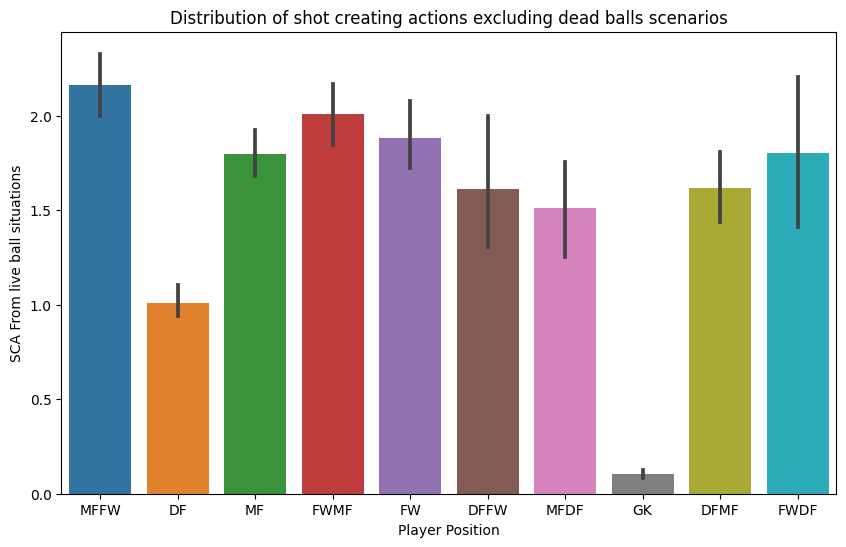

In [13]:
plt.figure(figsize=(10, 6))
sns.barplot(x=df["Pos"], y=df["ScaPassLive"])


plt.xlabel("Player Position")
plt.ylabel("SCA From live ball situations")
plt.title("Distribution of shot creating actions excluding dead balls scenarios")



plt.show()

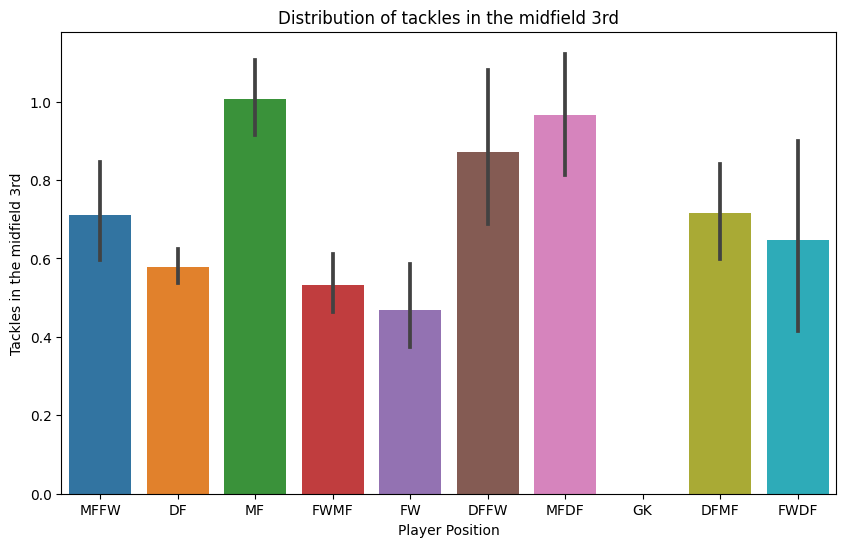

In [14]:
plt.figure(figsize=(10, 6))
sns.barplot(x=df["Pos"], y=df["TklMid3rd"])


plt.xlabel("Player Position")
plt.ylabel("Tackles in the midfield 3rd")
plt.title("Distribution of tackles in the midfield 3rd")



plt.show()

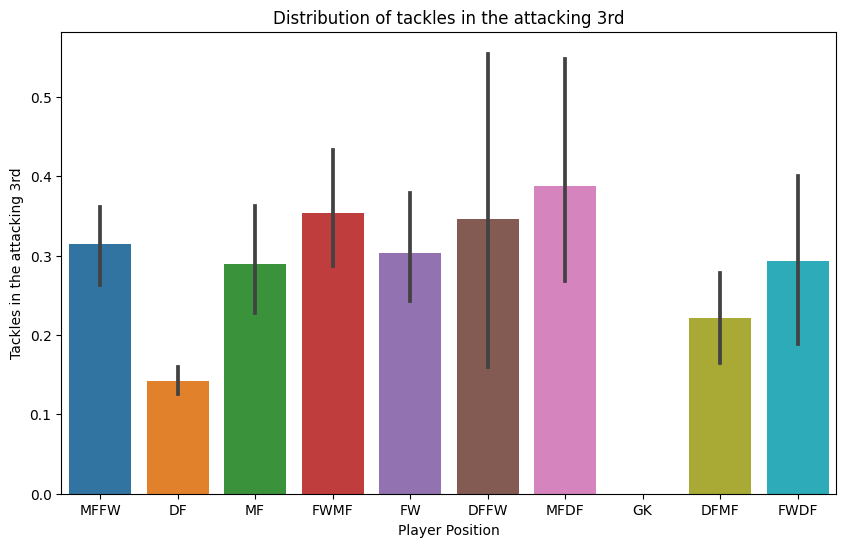

In [15]:
plt.figure(figsize=(10, 6))
sns.barplot(x=df["Pos"], y=df["TklAtt3rd"])


plt.xlabel("Player Position")
plt.ylabel("Tackles in the attacking 3rd")
plt.title("Distribution of tackles in the attacking 3rd")



plt.show()

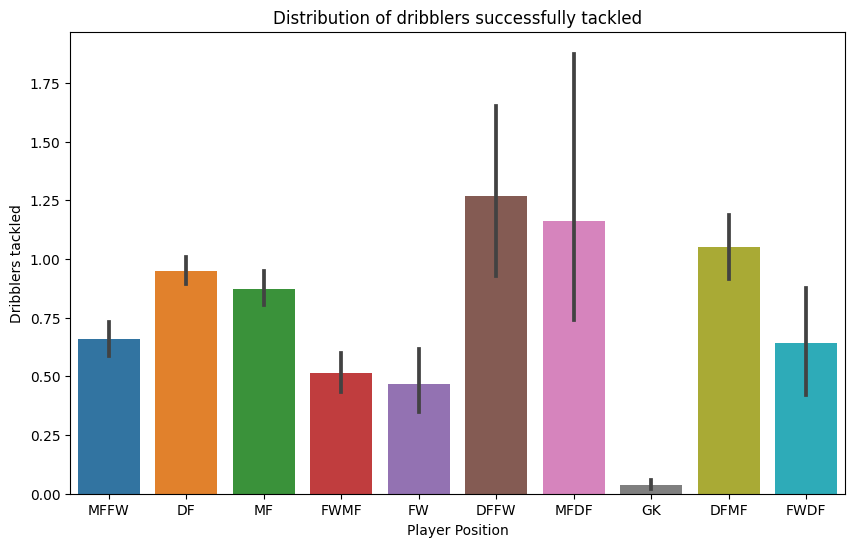

In [16]:
plt.figure(figsize=(10, 6))
sns.barplot(x=df["Pos"], y=df["TklDri"])


plt.xlabel("Player Position")
plt.ylabel("Dribblers tackled")
plt.title("Distribution of dribblers successfully tackled")



plt.show()

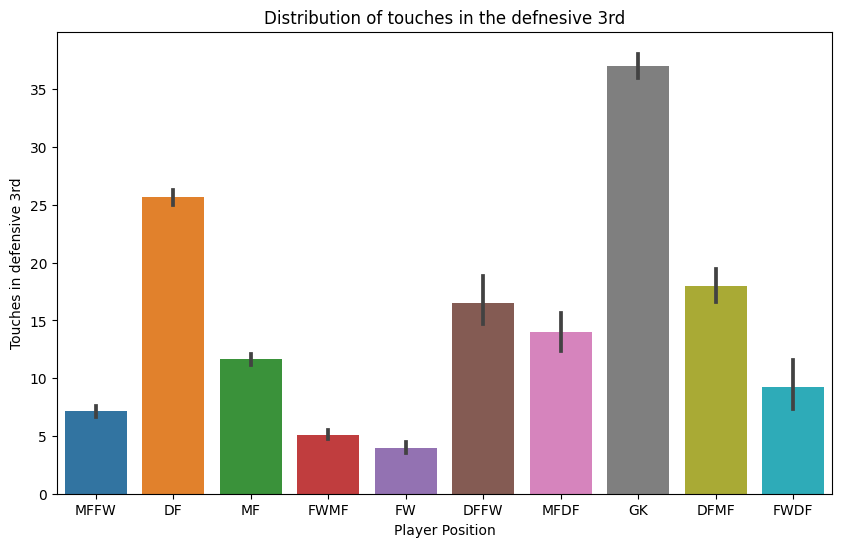

In [17]:
plt.figure(figsize=(10, 6))
sns.barplot(x=df["Pos"], y=df["TouDef3rd"])


plt.xlabel("Player Position")
plt.ylabel("Touches in defensive 3rd")
plt.title("Distribution of touches in the defnesive 3rd")



plt.show()

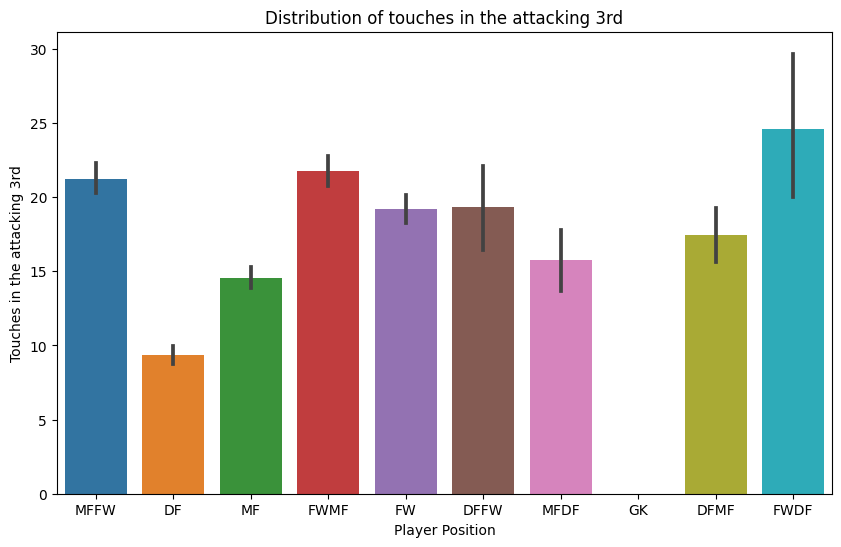

In [18]:
plt.figure(figsize=(10, 6))
sns.barplot(x=df["Pos"], y=df["TouAtt3rd"])


plt.xlabel("Player Position")
plt.ylabel("Touches in the attacking 3rd")
plt.title("Distribution of touches in the attacking 3rd")



plt.show()

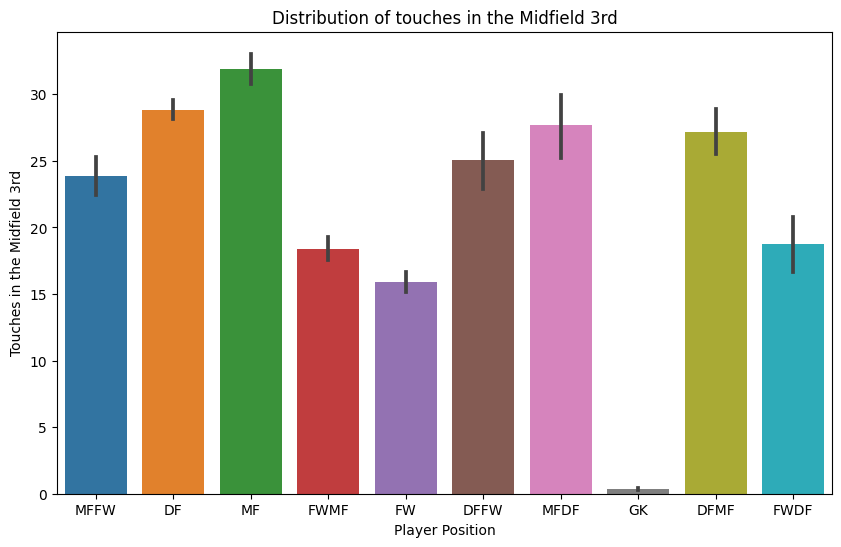

In [19]:
plt.figure(figsize=(10, 6))
sns.barplot(x=df["Pos"], y=df["TouMid3rd"])


plt.xlabel("Player Position")
plt.ylabel("Touches in the Midfield 3rd")
plt.title("Distribution of touches in the Midfield 3rd")



plt.show()

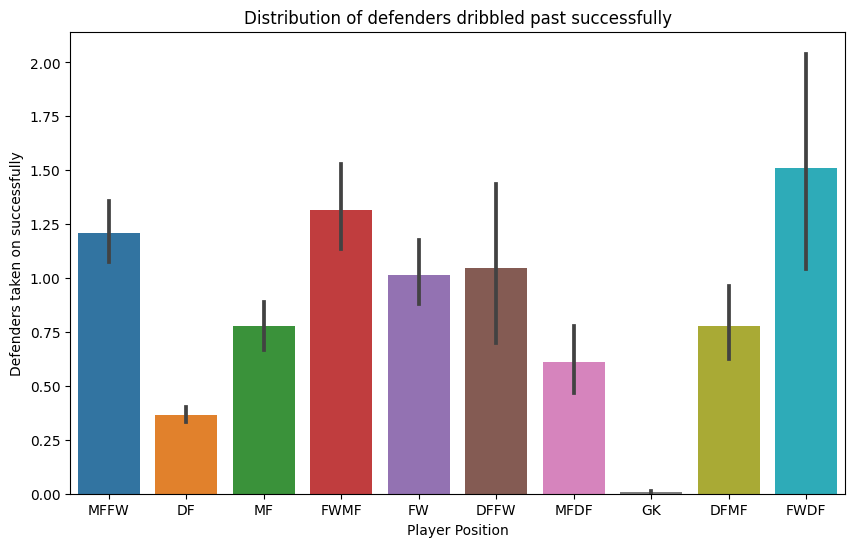

In [20]:
plt.figure(figsize=(10, 6))
sns.barplot(x=df["Pos"], y=df["ToSuc"])


plt.xlabel("Player Position")
plt.ylabel("Defenders taken on successfully")
plt.title("Distribution of defenders dribbled past successfully")



plt.show()

Here we can see the number of defenders successfully taken on while dribbling the ball. Players in more attacking, forward roles have the highest number of successful dribbles, in particular attacking players in wider roles as they have more opportunities to get one on one with the defender marking them. However, once again the error bars show a large variance in some of these positions suggesting that some players are exceptional dribblers of the ball whereas others prefer passing the ball more. With that being said, there is still a clear difference between positions and this feature making it a good potential predictor.

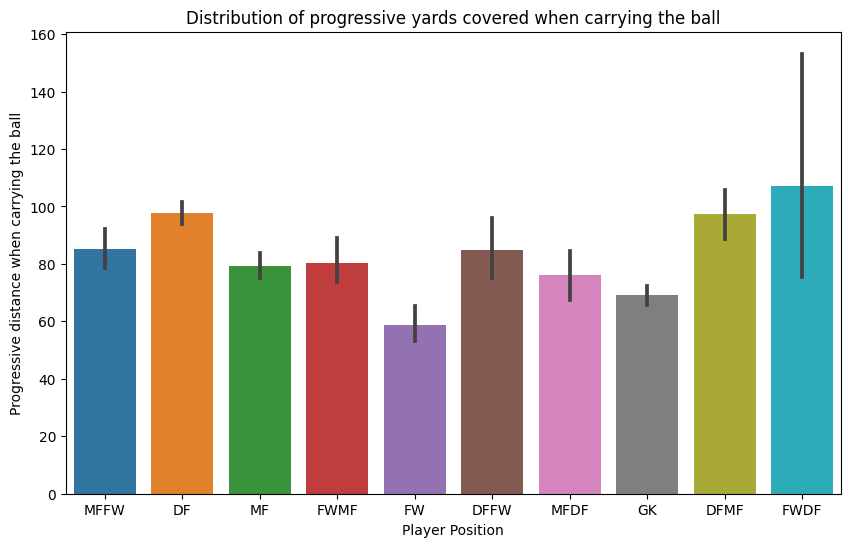

In [21]:
plt.figure(figsize=(10, 6))
sns.barplot(x=df["Pos"], y=df["CarPrgDist"])


plt.xlabel("Player Position")
plt.ylabel("Progressive distance when carrying the ball")
plt.title("Distribution of progressive yards covered when carrying the ball")



plt.show()

this graph shows the number of progressive yards covered when carrying the ball for each position in the dataset. Unlike the graph below, the difference between each position is not as clear and the error bars for most positions are small showing the values obtained are more consistent. The largest error bar seen is in the FWDF position suggesting that some players in this area carry the ball much more than others who do not carry the ball at all. Due to the difference between each position not being significantly large, no clear groups are created based on this feature and this would most likely make it a poor predictor for positioning.

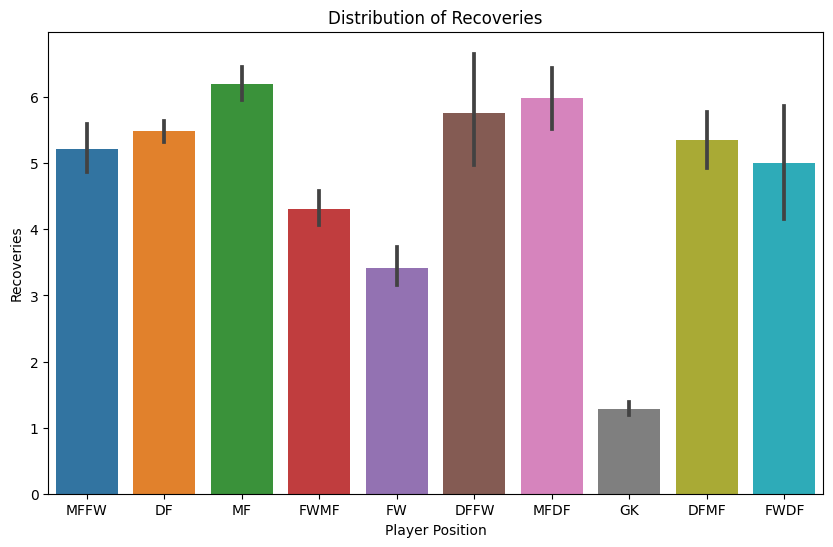

In [22]:
plt.figure(figsize=(10, 6))
sns.barplot(x=df["Pos"], y=df["Recov"])


plt.xlabel("Player Position")
plt.ylabel("Recoveries")
plt.title("Distribution of Recoveries")



plt.show()

This graph shows which positions have the highest number of recoveries. The tall bars with small error bars show the recoveries are more consistent and there is less spread. Taller error bars show a larger variance and suggest that some players within the position recover the ball a lot whereas others do not recover the ball at all. Based on this graph, midfield players tend to have the highest number of recoveries, followed by defensive positions and forwards have the fewest number of recoveries. This makes sense as most football matches are contested heavily in the midfield regions and whichever team wins the midfield battle tends to control to tempo of the game, giving them the ability to dictate how the game is played.

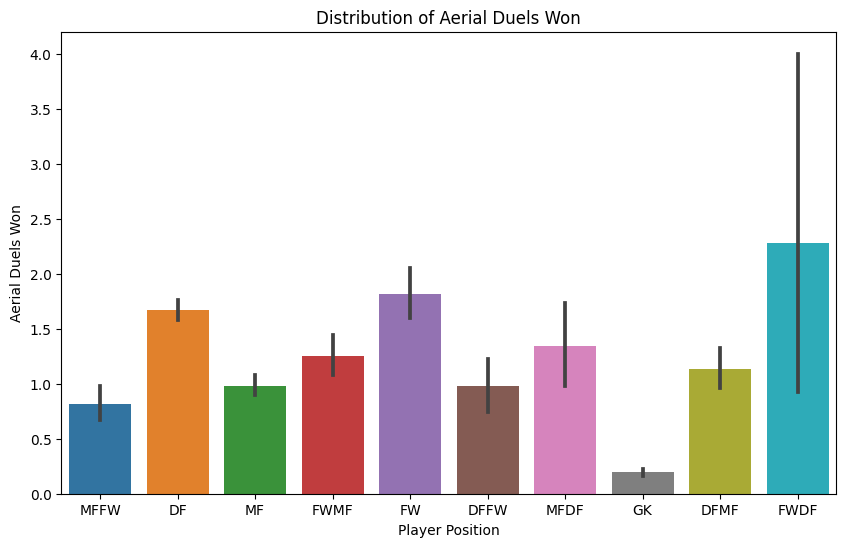

In [23]:
plt.figure(figsize=(10, 6))
sns.barplot(x=df["Pos"], y=df["AerWon"])


plt.xlabel("Player Position")
plt.ylabel("Aerial Duels Won")
plt.title("Distribution of Aerial Duels Won")



plt.show()

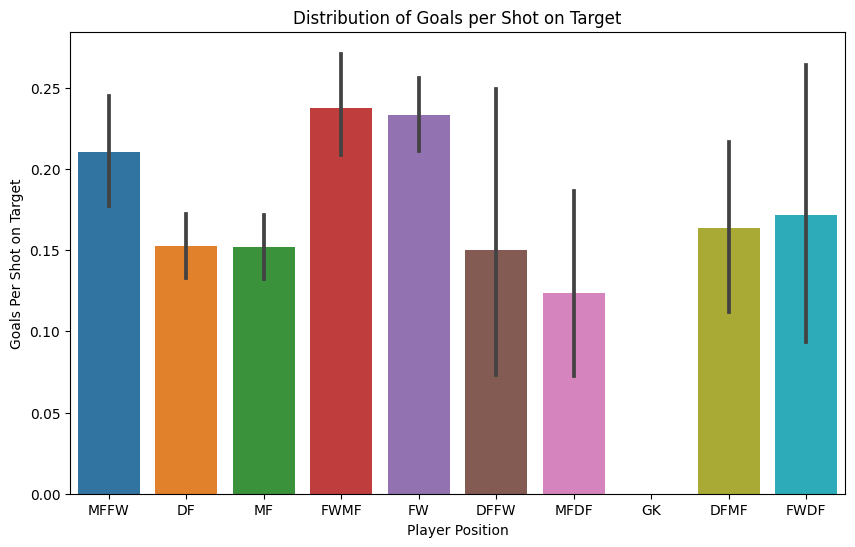

In [24]:
plt.figure(figsize=(10, 6))
sns.barplot(x=df["Pos"], y=df["G/SoT"])


plt.xlabel("Player Position")
plt.ylabel("Goals Per Shot on Target")
plt.title("Distribution of Goals per Shot on Target")



plt.show()

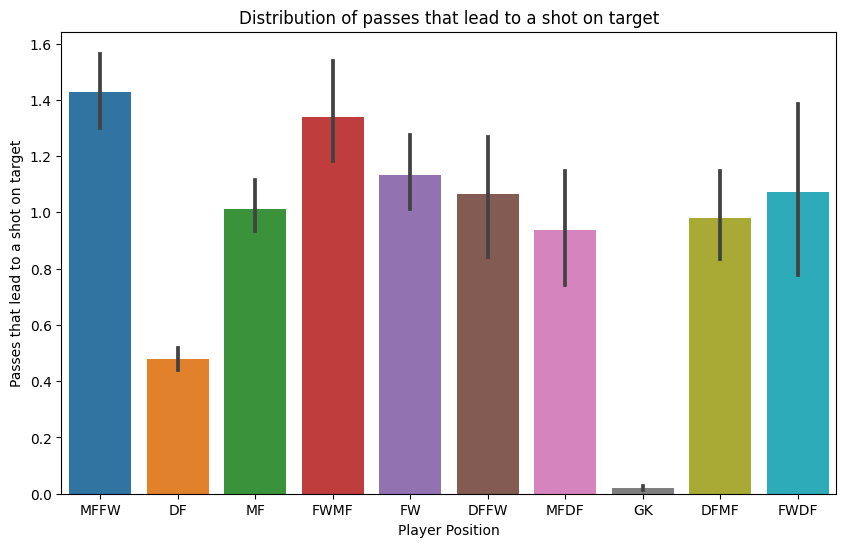

In [25]:
plt.figure(figsize=(10, 6))
sns.barplot(x=df["Pos"], y=df["PasAss"])


plt.xlabel("Player Position")
plt.ylabel("Passes that lead to a shot on target")
plt.title("Distribution of passes that lead to a shot on target")



plt.show()

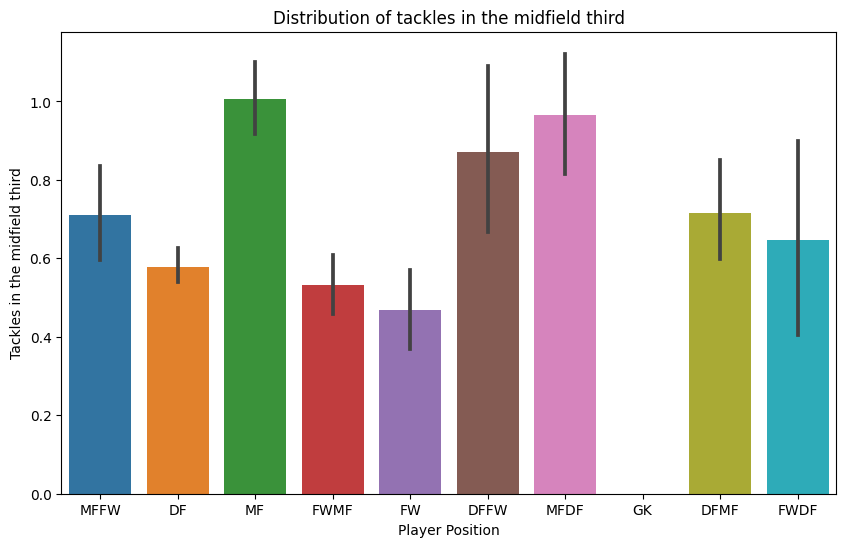

In [26]:
plt.figure(figsize=(10, 6))
sns.barplot(x=df["Pos"], y=df["TklMid3rd"])


plt.xlabel("Player Position")
plt.ylabel("Tackles in the midfield third")
plt.title("Distribution of tackles in the midfield third")



plt.show()

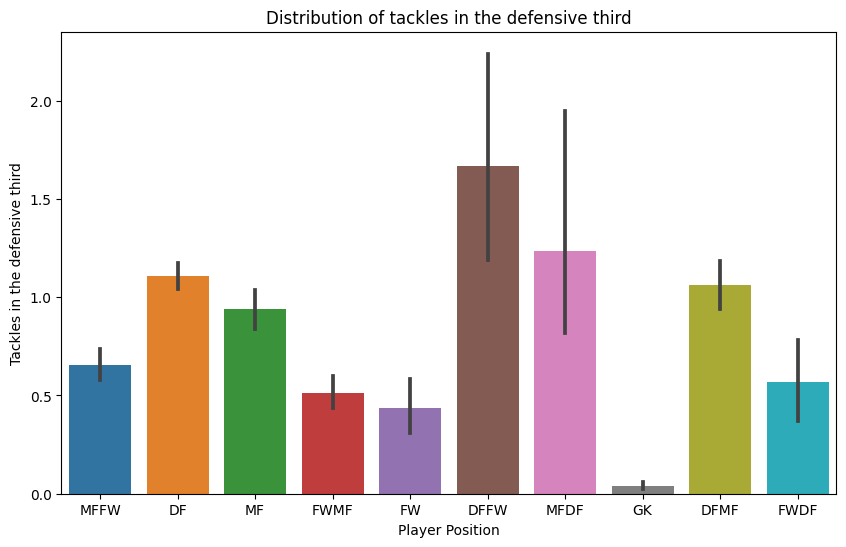

In [27]:
plt.figure(figsize=(10, 6))
sns.barplot(x=df["Pos"], y=df["TklDef3rd"])


plt.xlabel("Player Position")
plt.ylabel("Tackles in the defensive third")
plt.title("Distribution of tackles in the defensive third")



plt.show()

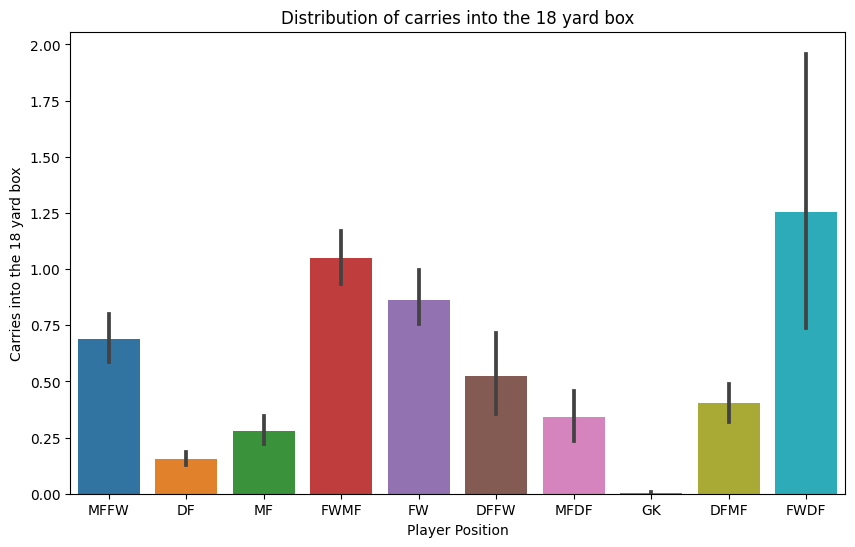

In [28]:
plt.figure(figsize=(10, 6))
sns.barplot(x=df["Pos"], y=df["CPA"])


plt.xlabel("Player Position")
plt.ylabel("Carries into the 18 yard box")
plt.title("Distribution of carries into the 18 yard box")



plt.show()

# Why were these features selected?
These features were selected to ensure that they were not mono dimensional and captured a wholistic view of the game, capturing parts of a player’s game that benefit the team and reflect their efficiency in these areas. Based on the exploratory data analysis, some of these features appeared to be good indicators as they formed distinct groups based on the feature focussed on. For example, forward players had more shots on target compared to midfield and defensive players. However, features like progressive distance covered when carrying the ball did not appear to be particularly good predictors for positions as they values were fairly equal throughout the positions and no distinct groups were formed. Based on these insights gained, the final set of features will remain the same but feature importances will be investigated to remove any redundant features for a more objective approach.

# Data cleaning and pre-processing
the required data cleaning and pre-processing does not involve imputation techniques to replace values of 0.00 with synthetic values such as the mode, mean and median. This would make the results less reliable as these would be values that players did not obtain naturally and could lead to them being misclassified by the model. Therefore, the majority of cleaning and pre-processing will be done to handle any missing or duplicate values and converting categorical values to numerical values. Due to decision trees splitting data based on thresholds being reached, the need for normalisation and transformation techniques such as standard scaling are also not required. Before cleaning and pre-processing the data, a copy of the dataset was created containing only the technical features mentioned previously and players with less than 10 games either played or started were dropped. Although dropping these players significantly reduced the size of the dataset, it still replicates real life scouting scenarios as scouts monitor a smaller pool of players rather than trying to monitor thousands, as this would be inefficient, if not, impossible for them to do.

In [29]:
df = df[(df['MP'] >= 10) & (df['Starts'] >= 10)]

In [30]:
technical_features = ['SoT','G/SoT','SCA','ScaPassLive','PasAss','ToSuc','AerWon','PasTotPrgDist','Pas3rd','PasProg','Recov','CarPrgDist','CPA','TklDri','TklDriPast','Pos','TklDef3rd','TklMid3rd','TklAtt3rd','TouDef3rd','TouMid3rd','TouAtt3rd','Player']
df2 = df[technical_features].copy()

# Handling missing and duplicate values 
The dataset being worked with was good in the sense that the number of inconsistencies seen in the data were low. Any duplicate values were caused by players going on loan spells during the season meaning they had stats from both their parent club and loan club.

firstly goalkeepers are removed from the dataset as they are not part of the classification task. The duplicate values are then searched for using the ‘Player’ category. Although this category will not be used when classifying positions, it was necessary for searching duplicate values as all of the duplicates were players and not statistical metrics. There was only one duplicate value present, so this value was dropped using drop_duplicates within the player subset.
In terms of null values, the dataset was extremely well maintained as it contained 0 null values, which can be seen below. This meant that no null values needed to be dropped, and the next phase of data preparation can be continued with.


In [31]:
df2 = df2[df2['Pos'] != 'GK']

In [32]:
print(df2['Player'].duplicated().sum())

1


In [33]:
df2 = df2.drop_duplicates(subset='Player')

In [34]:
print(df2['Player'].duplicated().sum())

0


In [35]:
print("Duplicates:", df2['Player'].duplicated().sum())
print(df2.isnull().sum())

Duplicates: 0
SoT              0
G/SoT            0
SCA              0
ScaPassLive      0
PasAss           0
ToSuc            0
AerWon           0
PasTotPrgDist    0
Pas3rd           0
PasProg          0
Recov            0
CarPrgDist       0
CPA              0
TklDri           0
TklDriPast       0
Pos              0
TklDef3rd        0
TklMid3rd        0
TklAtt3rd        0
TouDef3rd        0
TouMid3rd        0
TouAtt3rd        0
Player           0
dtype: int64


# Handling class imbalances
During the EDA process we explored the distribution of different positions across the dataset. This exploratory data analysis highlighted the significant imbalances between hybrid and traditional positions. These imbalances must be handled as the decision tree requires a good number of samples to base the predictions off and if certain classes are underrepresented within the data, then classifying these positions will become significantly more difficult, leading to lower accuracy scores. As some of the hybrid positions are very similar to traditional positions, they have been combined to not only reduce the number of classes being classified but also to ensure that each position is represented equally. 

MFFW and FWMF represented players who play across five potential positions which were left or right wing, left or right midfield or as a central attacking midfielder. The main focus of these positions is to pose an attacking threat with less emphasis on defending, although these players are still expected to drop slightly deeper during build up play and defensive scenarios, the majority of their game is spent attacking the opposition goal and getting into high xG (expected goals) zones which are closest to the oppositions goal. Therefore, both MFFW and FWMF players can be combined with FW players to ensure there is no imbalance. This not only benefits the model when making predictions but also reflects the secondary positions of some players in real life. For example, Karim Adeyemi was listed as a FWMF in the dataset which represented left or right midfield players. However, in game Adeyemi has featured as both a left and right winger as well as a striker in some games emphasising how these types of players are often placed in the midfield as part of the current tactical set up employed by the coach but during the game, play as additional forwards to create a numerical advantage when attacking.
This is further emphasised during the exploratory data analysis, as players in these two hybrid positions performed similarly to forward players in terms of shots on target.


As for MFDF and DFMF players, they can be combined with traditional midfield players as they operate in very similar zones during the game. When looking at the number of recoveries in these two positions are also very similar to those seen with traditional midfield players, emphasising that these positions are very similar with the only difference being how frequently they get forward to support attacks.

The two final positions that remain are FWDF and DFFW which represent left or right fullbacks and wingbacks. These two positions on the pitch are defenders with slightly different roles with DFFW players inverting into the midfield and FWDF players overlapping to provide more attacking support. These two types of players are difficult to place into one category as the EDA showed that DFFW players were very similar to midfield players in terms of recoveries but also showed that FWDF players performed similarly to forward players in terms of defenders dribbled past successfully. This emphasised the difference between the two roles these players have however, as their primary position is in the defensive areas of the pitch, they were combined with the DF position.

In [36]:
position_mapping = {
    'DF': 'DF',      
    'DFFW': 'DF',    
    'FWDF': 'DF',    
    'DFMF': 'MF',    
    'MF': 'MF',      
    'MFDF': 'MF',    
    'FW': 'FW',      
    'FWMF': 'FW',    
    'MFFW': 'FW',    
}

df2['Pos'] = df2['Pos'].replace(position_mapping)

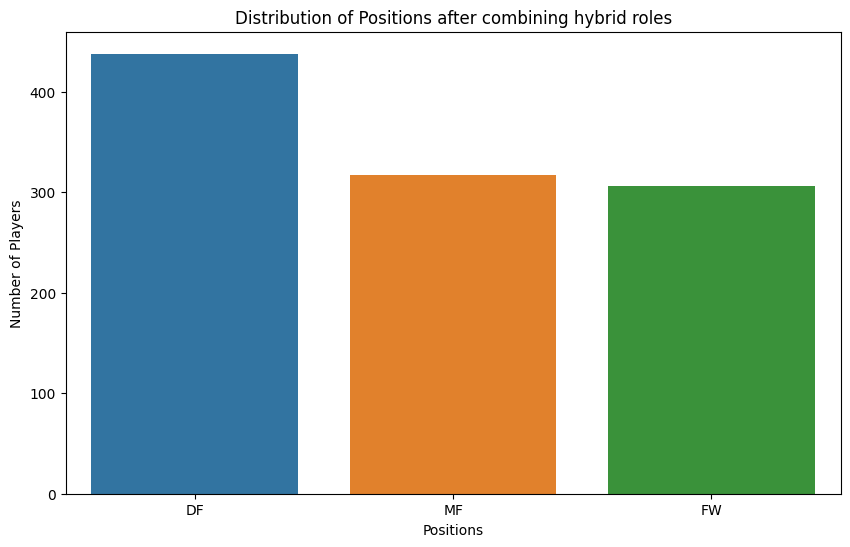

Pos
DF    41.281810
MF    29.877474
FW    28.840716
Name: proportion, dtype: float64


In [37]:
position_counts = df2["Pos"].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=position_counts.index, y=position_counts.values)


plt.xlabel("Positions")
plt.ylabel("Number of Players")
plt.title("Distribution of Positions after combining hybrid roles")



plt.show()
print(df2["Pos"].value_counts(normalize=True) * 100)


Although an understanding of the versatility of a player is lost, probability outputs can be introduced to mitigate such instances. By analysing the distribution of prediction outputs, players with probabilities over the threshold of 30% can be flagged as being versatile in more than one area of the pitch, allowing scouts to still gain insight into the different roles this player could be employed in.

In [38]:
df2['Pos'].value_counts()

Pos
DF    438
MF    317
FW    306
Name: count, dtype: int64

In [39]:
df2.drop(columns=['Player']) 

,SoT,G/SoT,SCA,ScaPassLive,PasAss,ToSuc,AerWon,PasTotPrgDist,Pas3rd,PasProg,...,CPA,TklDri,TklDriPast,Pos,TklDef3rd,TklMid3rd,TklAtt3rd,TouDef3rd,TouMid3rd,TouAtt3rd
0,0.28,0.20,3.62,2.37,1.75,1.19,0.34,85.7,1.75,3.22,...,0.40,0.51,0.96,FW,0.45,0.90,0.28,4.35,19.0,21.50
1,0.05,0.00,1.14,0.86,0.27,0.32,2.18,318.5,2.91,4.50,...,0.09,1.32,0.36,DF,1.45,1.00,0.05,27.50,29.5,2.73
3,0.15,0.33,1.60,1.35,0.50,0.70,0.50,226.9,6.00,5.60,...,0.15,0.85,0.45,MF,0.55,0.85,0.10,12.00,49.6,12.20
4,0.00,0.00,1.24,1.01,0.62,0.54,0.31,224.7,3.88,5.04,...,0.00,1.32,1.94,MF,2.64,1.16,0.00,19.20,31.4,4.88
9,1.02,0.29,2.34,1.32,0.54,1.02,0.42,49.6,0.78,1.80,...,1.14,0.30,1.02,FW,0.54,0.30,0.30,5.45,14.6,18.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2680,0.21,0.33,0.28,0.21,0.00,0.00,2.61,228.2,0.63,1.13,...,0.00,0.21,0.21,DF,0.14,0.14,0.00,32.70,17.9,1.27
2682,0.07,1.00,0.43,0.36,0.14,0.07,2.00,311.5,2.00,3.36,...,0.07,0.86,0.21,DF,1.00,0.43,0.00,29.10,29.7,3.00
2683,0.11,0.50,1.29,1.24,0.51,0.22,2.19,251.1,4.94,5.45,...,0.06,0.73,0.56,MF,0.67,1.07,0.22,16.90,38.5,6.57
2686,0.86,0.50,5.08,3.53,2.30,1.28,0.48,181.2,3.53,7.54,...,0.96,0.21,0.70,MF,0.37,0.48,0.16,5.61,23.7,28.20


# Label encoding for the one categorical value within the dataset

In [40]:
labelEncoder = LabelEncoder()

df2['Pos_encoded'] = labelEncoder.fit_transform(df2['Pos'])

y = df2['Pos_encoded']

print(dict(zip(labelEncoder.classes_, labelEncoder.transform(labelEncoder.classes_))))





{'DF': 0, 'FW': 1, 'MF': 2}


In [41]:
df2.drop(columns=['Player']) 

,SoT,G/SoT,SCA,ScaPassLive,PasAss,ToSuc,AerWon,PasTotPrgDist,Pas3rd,PasProg,...,TklDri,TklDriPast,Pos,TklDef3rd,TklMid3rd,TklAtt3rd,TouDef3rd,TouMid3rd,TouAtt3rd,Pos_encoded
0,0.28,0.20,3.62,2.37,1.75,1.19,0.34,85.7,1.75,3.22,...,0.51,0.96,FW,0.45,0.90,0.28,4.35,19.0,21.50,1
1,0.05,0.00,1.14,0.86,0.27,0.32,2.18,318.5,2.91,4.50,...,1.32,0.36,DF,1.45,1.00,0.05,27.50,29.5,2.73,0
3,0.15,0.33,1.60,1.35,0.50,0.70,0.50,226.9,6.00,5.60,...,0.85,0.45,MF,0.55,0.85,0.10,12.00,49.6,12.20,2
4,0.00,0.00,1.24,1.01,0.62,0.54,0.31,224.7,3.88,5.04,...,1.32,1.94,MF,2.64,1.16,0.00,19.20,31.4,4.88,2
9,1.02,0.29,2.34,1.32,0.54,1.02,0.42,49.6,0.78,1.80,...,0.30,1.02,FW,0.54,0.30,0.30,5.45,14.6,18.70,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2680,0.21,0.33,0.28,0.21,0.00,0.00,2.61,228.2,0.63,1.13,...,0.21,0.21,DF,0.14,0.14,0.00,32.70,17.9,1.27,0
2682,0.07,1.00,0.43,0.36,0.14,0.07,2.00,311.5,2.00,3.36,...,0.86,0.21,DF,1.00,0.43,0.00,29.10,29.7,3.00,0
2683,0.11,0.50,1.29,1.24,0.51,0.22,2.19,251.1,4.94,5.45,...,0.73,0.56,MF,0.67,1.07,0.22,16.90,38.5,6.57,2
2686,0.86,0.50,5.08,3.53,2.30,1.28,0.48,181.2,3.53,7.54,...,0.21,0.70,MF,0.37,0.48,0.16,5.61,23.7,28.20,2


In [42]:
X = df2.drop(columns=['Pos_encoded','Pos','Player']) 


# Model Training

To develop the classification model, the dataset was first split into training and testing sets using the train_test_split function. Specifically, 80% of the data was allocated to the training set and 20% to the testing set. A random seed (random_state=91) was specified to ensure reproducibility of results across different runs. Following the split, a Decision Tree Classifier was created with a set of tuned hyperparameters to improve model performance and address challenges such as class imbalance and overfitting.


Firstly, the splitting criterion was set to entropy (criterion='entropy'), meaning that information gain was used to determine the best splits at each node. This approach prioritises splits that maximise the reduction in uncertainty, leading to more informative splitting of the data. A maximum depth (max_depth=5) was imposed to control the complexity of the tree and prevent overfitting. Limiting the depth ensures the model captures only the most meaningful patterns without memorising noise in the training data. To address class imbalance within the positional categories, a balanced class weighting (class_weight='balanced') was applied. This adjustment helped the model treat minority classes with equal importance during learning, leading to fairer classification outcomes. 


Additionally, cost-complexity pruning (ccp_alpha=0.006) was used to further simplify the tree by eliminating branches that did not contribute significantly to reducing the overall error. This encourages a simpler and more generalisable model. Thresholds for minimum samples required to split a node (min_samples_split=15) and minimum samples required at a leaf node (min_samples_leaf=2) were set. 

These hyperparameters ensured that each decision was based on a statistically meaningful subset of the data, promoting stability and reducing the risk of overfitting to small sample fluctuations.
The model was then trained on the X_train and y_train datasets using the fit method. 


This training phase allowed the decision tree to learn relationships between player features and their corresponding roles, considering technical skill indicators and role-specific behaviours. Through the careful combination of entropy-based splitting, depth and complexity control, class balancing, statistical stability, and reproducibility measures, the training was designed to produce an interpretable and trustworthy decision tree model for player role classification. 


In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=91, test_size=0.2)


In [44]:
from sklearn import tree 
clf = DecisionTreeClassifier(criterion='entropy',max_depth=5)
clf = DecisionTreeClassifier(class_weight="balanced", random_state=91,ccp_alpha=0.006,min_samples_split=15, min_samples_leaf=2)
clf = clf.fit(X_train,y_train) 


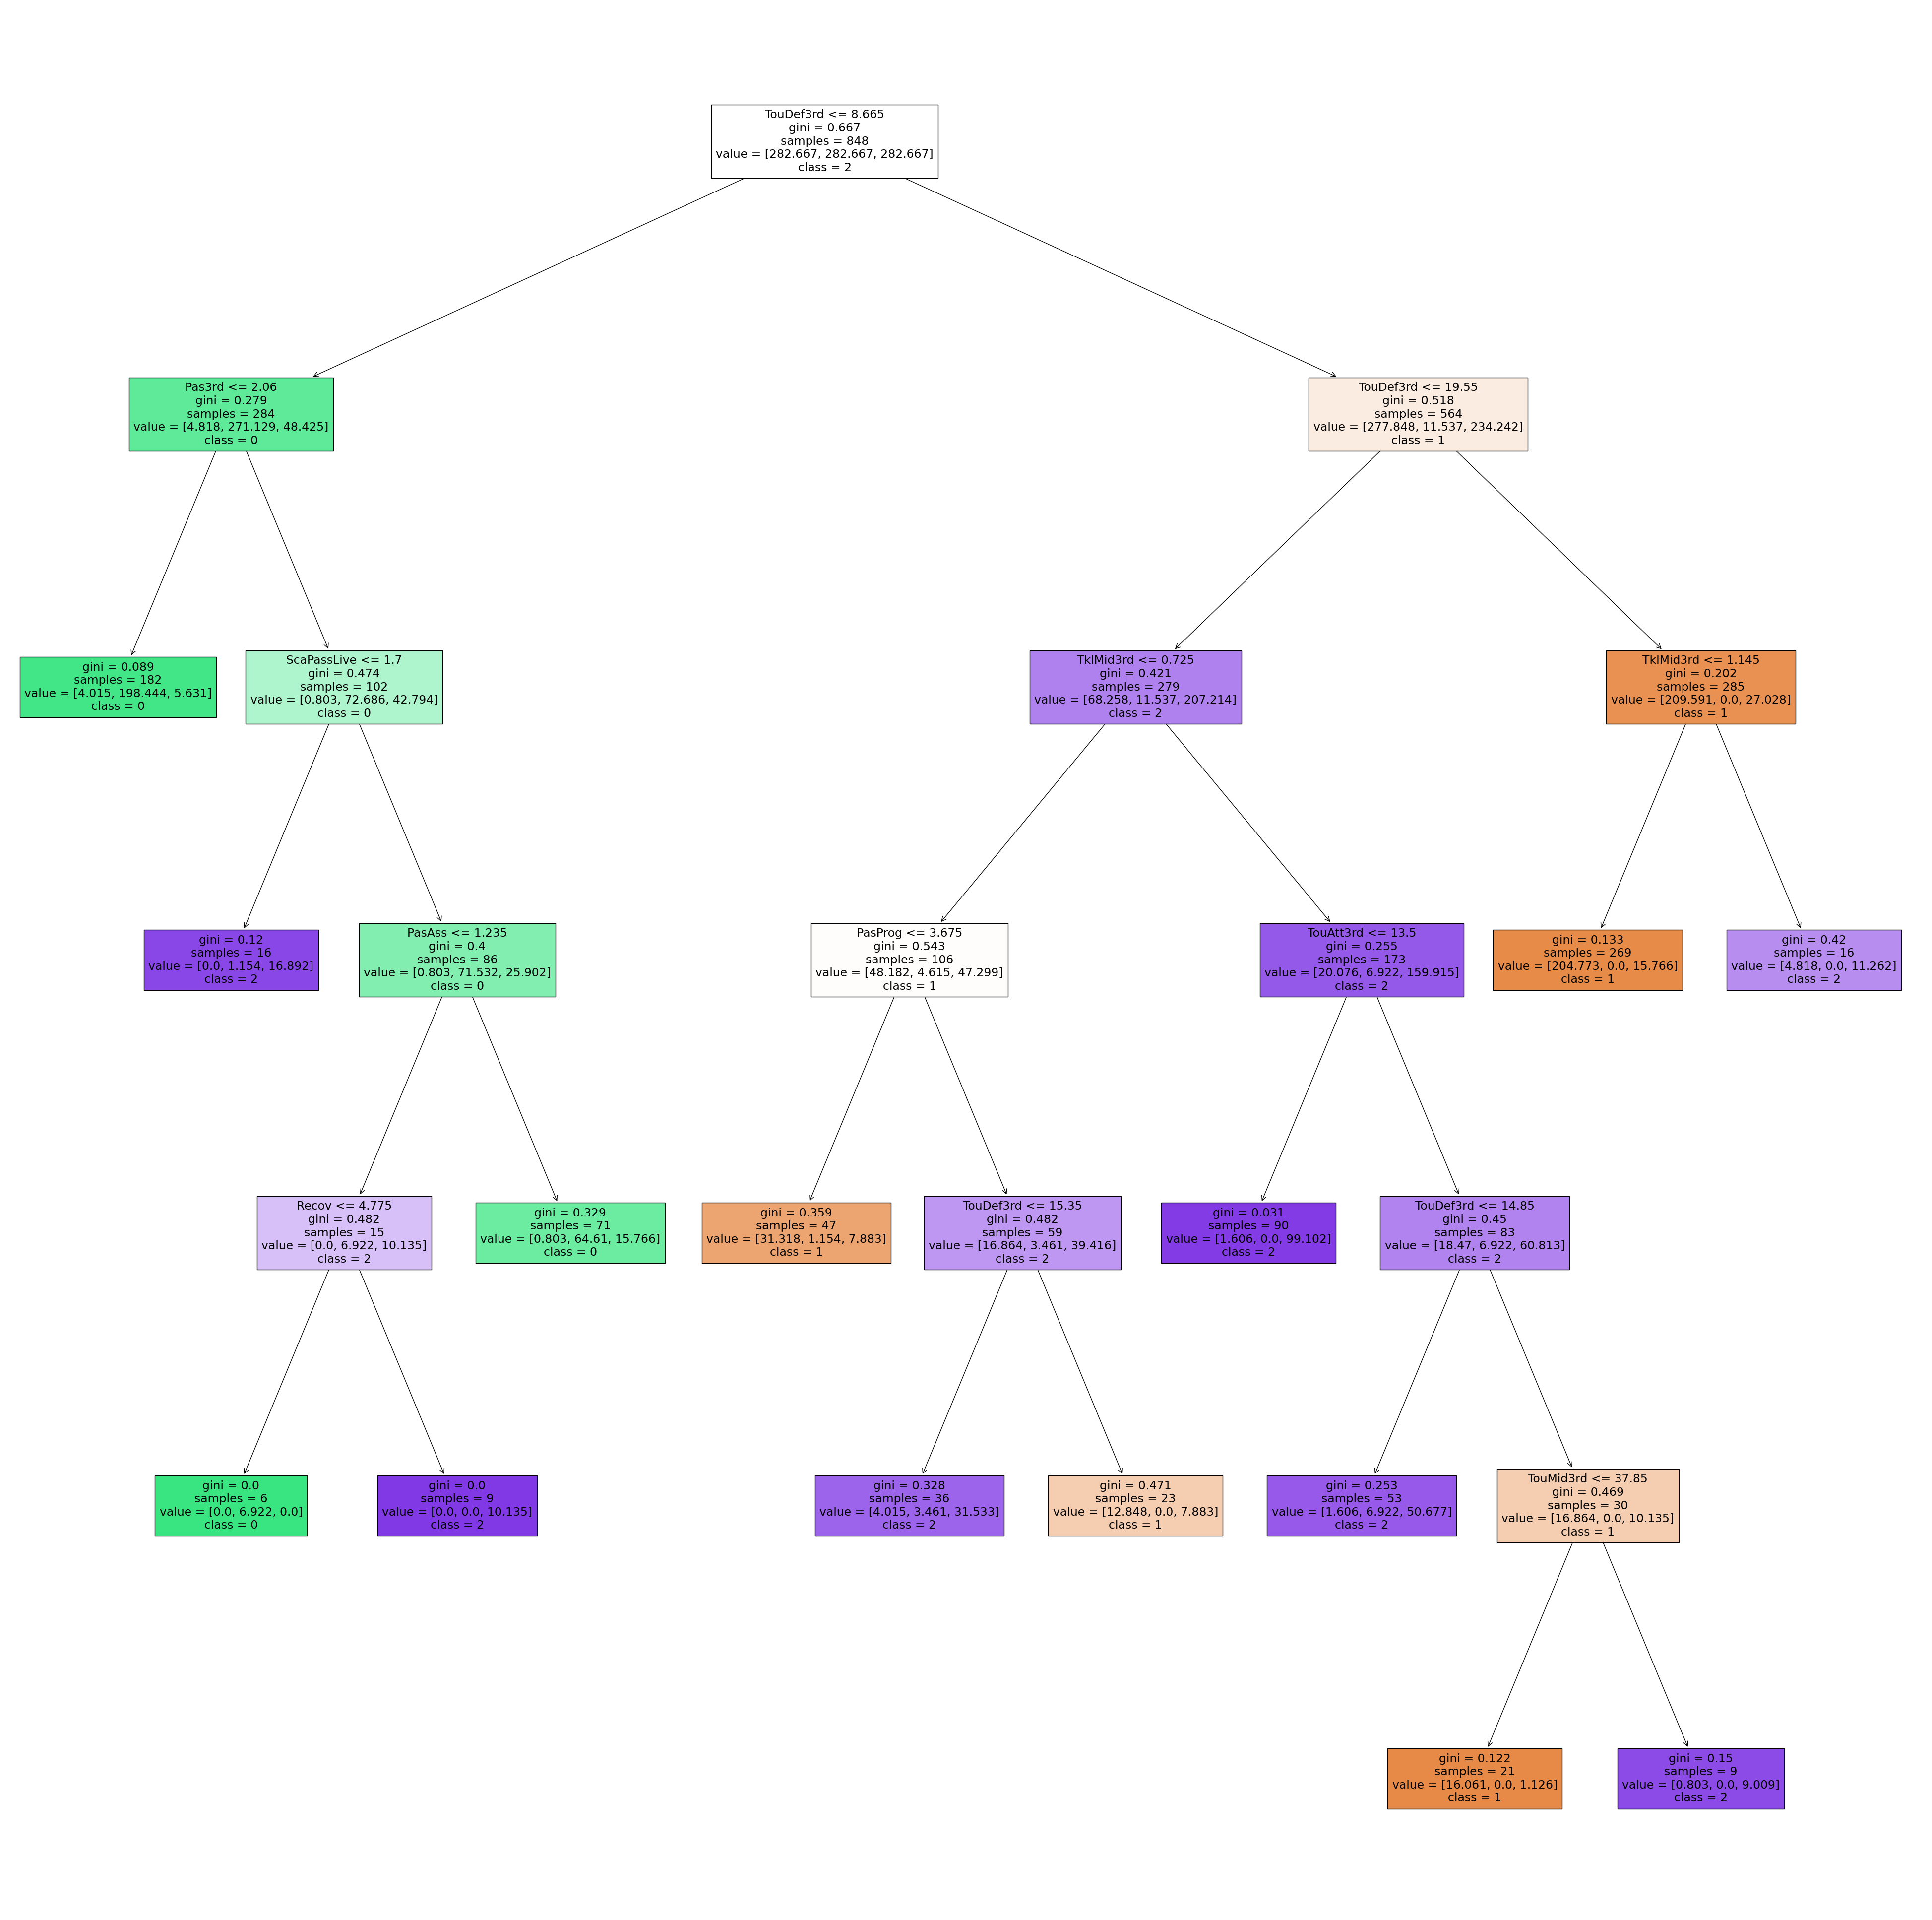

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [45]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Plot the tree
plt.figure(figsize=(50,50))
plot_tree(clf, feature_names=X.columns, class_names=[str(cls) for cls in y.unique()], filled=True)
plt.show()
plt.savefig('tree.png',bbox_inches='tight')

In [ ]:
from sklearn import metrics 
from sklearn.metrics import classification_report 

y_train_pred = clf.predict(X_train)

print("Training Accuracy:", metrics.accuracy_score(y_train, y_train_pred))
print("Training Classification Report:\n", classification_report(y_train, y_train_pred))

y_test_pred = clf.predict(X_test)

print("Testing Accuracy:", metrics.accuracy_score(y_test, y_test_pred))
print("Testing Classification Report:\n", classification_report(y_test, y_test_pred))

Training Accuracy: 0.9044811320754716
Training Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.94      0.93       352
           1       0.90      0.96      0.93       245
           2       0.89      0.81      0.85       251

    accuracy                           0.90       848
   macro avg       0.90      0.90      0.90       848
weighted avg       0.90      0.90      0.90       848

Testing Accuracy: 0.8356807511737089
Testing Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.91      0.89        86
           1       0.88      0.85      0.87        61
           2       0.74      0.73      0.73        66

    accuracy                           0.84       213
   macro avg       0.83      0.83      0.83       213
weighted avg       0.84      0.84      0.84       213



# Performance results
The performance resuslts seen here show a significant improvement in terms of overfitting as the accuracy score for the training data has now dropped to 0.90. Although this technically means the accuracy has dropped, it shows the model is now learning specific metrics which are unique to certain roles rather than memorising the training data. This can be clearly seen as the accuracy scores for the testing data have now improved from 0.77 to 0.84 which is only a 0.06 difference from the accuracy score seen in the training. 

This marginal difference between the accuracy scores now shows the model is better prepared to make generalisable claims and emphasises the importance of the hyperparameters selected. In addition to this, the model is classifying midfield players better than before as the precision, recall and F1 scores have gone from 0.63, 0.68 and 0.66 to 0.74, 0.73 and 0.73. This still shows that the model is struggling in this department however, once the prediction probabilities are investigated, it will be clearer whether these are actually being caused by versatile players or if the model generally struggles when dealing with midfield players. 

The initial performance results before hyperparameter tuning can be seen below:

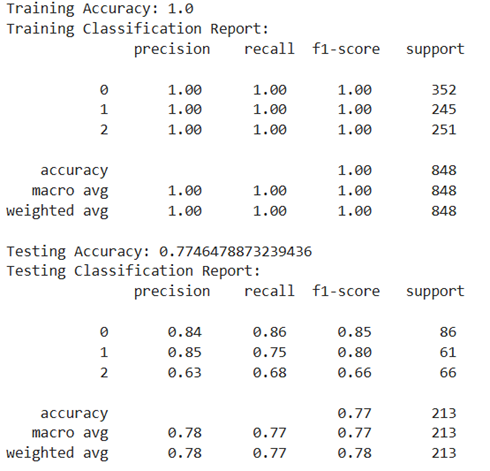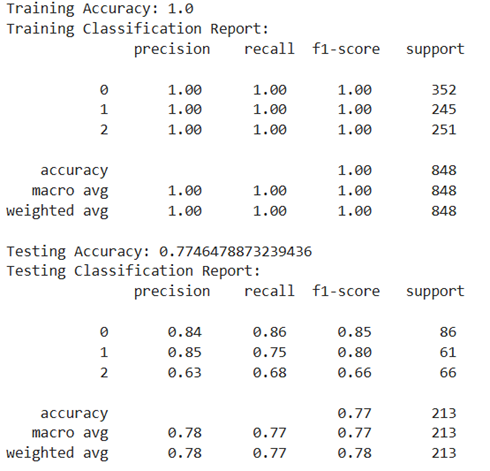
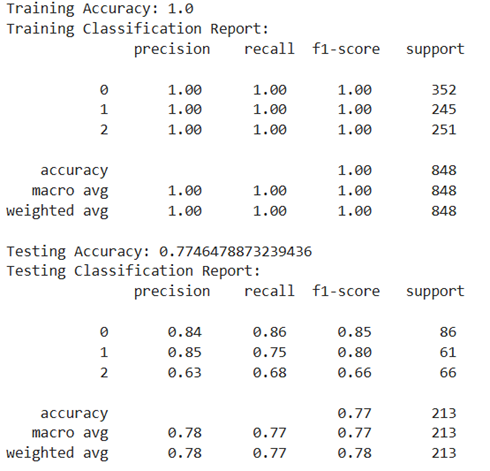
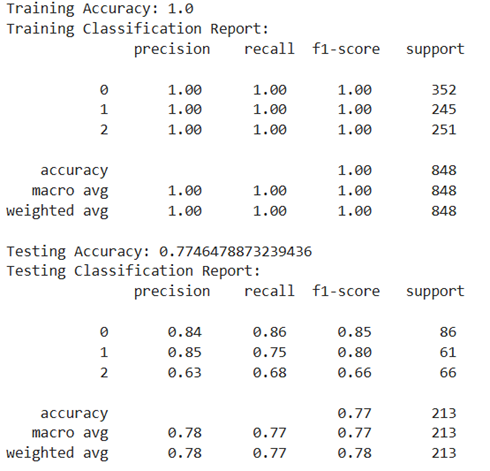

Based on these performance results, the overfitting seen in the initial implementation of the decision tree has been addressed effectively through the use of hyperparameter tuning such as maximum tree depth limitation and cost-complexity pruning. By using these specific set of hyperparameters, a model with the ability to make strong, generalisable predictions has been produced which was emphasised through the lower accuracy scores seen in the training and higher accuracy scores seen in the testing. 

Although some misclassifications were observed, these are not necessarily indicative of model failure. Given the fluid and dynamic nature of football, players often perform a variety of roles depending on tactical instructions, match context, and individual versatility. Furthermore, as the goal of this project was to find the best suited position for a player, these misclassifications may not necessarily be incorrect and could be the down to the model placing players into positions they are better suited to based on their technical metrics rather than adhering to combined positions they were put in. 

As a result of this, these misclassifications may reveal deeper insights in the field of football scouting, highlighting the practical value of the model not just for accurate role detection, but also for uncovering hidden tactical potential during the scouting and recruitment process.

# Prediction Probabilities
When hybrid and traditional roles were combined, an idea of how versatile a player is was slightly lost as they were now being combined with players who operate in similar areas and have similar traits to them in game. This was done to improve the overall accuracy of the model which clearly worked as seen in the performance results. 

However, handling versatile players was an area which was handled poorly in the existing literature and one of the main goals of this project was to handle these types of players effectively as they are crucial to squad planning and development. When the model was initially fitted, the method .predict() was used to predict the class label for each sample within the dataset based on their positional and technical metrics. To explore player versatility, the .predict_proba() method was introduced as it showed the probability distribution across the potential roles the player could operate in. A threshold value of 30% was set as the minimum value required to be considered as being versatile however, values extremely close to this value were also considered and investigated to assess whether this threshold was too high or low based on the most versatile players returned.

A player ID column is also created using the index values so that players can be identified. The versatility was then calculated by doing 1 minus the probability, this meant that the results could be interpreted as percentages similar to those seen in the performance metrics. The data frame was then filtered to show the most versatile players first. The 30% threshold value was now seen as a good choice as the most versatile players within the dataset sit either very close to this value or just above the threshold. To investigate whether this approach does accurately capture versatile players who can operate in multiple positions the player id values were searched using the .loc method which returned the players technical metrics along with their name and position.

In [47]:
probability = clf.predict_proba(X_test)


In [48]:
probability_df = pd.DataFrame(probability, columns=['DF Probability', 'FW Probability', 'MF Probability'])
probability_df['Player ID'] = X_test.index
print(probability_df)

     DF Probability  FW Probability  MF Probability  Player ID
0          0.102929        0.088729        0.808342       2385
1          0.928510        0.000000        0.071490       2581
2          0.928510        0.000000        0.071490        665
3          0.619753        0.000000        0.380247       1409
4          0.928510        0.000000        0.071490        906
..              ...             ...             ...        ...
208        0.019295        0.953645        0.027060       1520
209        0.928510        0.000000        0.071490       2299
210        0.299642        0.000000        0.700358       2536
211        0.776066        0.028590        0.195344       2155
212        0.776066        0.028590        0.195344       1393

[213 rows x 4 columns]


In [49]:
versatility = 1 - probability_df[['DF Probability', 'FW Probability', 'MF Probability']].max(axis=1)
probability_df['Versatility'] = versatility
most_versatile_count  = probability_df.sort_values(by='Versatility', ascending=False)
print(most_versatile_count.head(10))

     DF Probability  FW Probability  MF Probability  Player ID  Versatility
167        0.619753             0.0        0.380247       2650     0.380247
42         0.619753             0.0        0.380247       1572     0.380247
17         0.619753             0.0        0.380247       1648     0.380247
3          0.619753             0.0        0.380247       1409     0.380247
126        0.619753             0.0        0.380247       2469     0.380247
94         0.619753             0.0        0.380247        556     0.380247
147        0.619753             0.0        0.380247       1051     0.380247
193        0.619753             0.0        0.380247        418     0.380247
168        0.299642             0.0        0.700358        450     0.299642
171        0.299642             0.0        0.700358       1337     0.299642


# Player Selector
Here we see player 450 being selected from the data frame and their information is displayed. Player 450 was Manchester United midfielder Casemiro, according to the probability data frame, Casemiro was the 9th most versatile player within the dataset with a probability of 70% in the midfield position and 29.96% in the defender position. When looking into reliable sources such as transfermarkt.com and Whoscored.com, Casemiro’s main position is defensive midfield with his secondary roles being central midfield and central defender, as he has not featured in many games during the 2024/2025 season the stats from the 2023/2024 season were investigated. 

The results show that Casemiro played 19 games as a defensive midfielder and 6 as a central defender, emphasising his versatility across both midfield and defensive roles within the side. This also shows that the minimum threshold value of 30% when assessing a player’s versatility is highly precise and accurate, allowing scouts to investigate different roles a player could be employed in throughout the season to ensure the team can deal with suspensions and injuries if they arise, by recruiting players who are able to excel in different areas.

In addition to this, this resolves the issue of misclassification. As previously mentioned, some players were misclassified however, it was slightly unclear as to whether these players were misclassified or if the model was suggesting a better suited role for the player. These prediction probabilities can now be used alongside the classification to determine whether the model did in fact make an error or if the player is versatile and has the ability to play in the role assigned by the decision tree.

In [50]:
playerSelector = df2.loc[450]
print(playerSelector)

SoT                  0.36
G/SoT                 0.4
SCA                  3.14
ScaPassLive          2.77
PasAss               1.17
ToSuc                0.29
AerWon               2.34
PasTotPrgDist       286.0
Pas3rd               5.62
PasProg              5.99
Recov                7.81
CarPrgDist           55.1
CPA                   0.0
TklDri               2.12
TklDriPast           1.31
Pos                    MF
TklDef3rd            1.97
TklMid3rd            1.68
TklAtt3rd            0.44
TouDef3rd            23.1
TouMid3rd            41.4
TouAtt3rd            13.2
Player           Casemiro
Pos_encoded             2
Name: 450, dtype: object


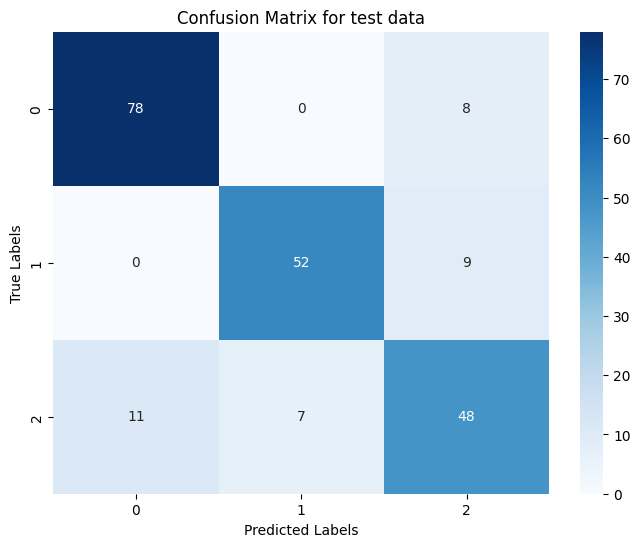

In [51]:
from sklearn.metrics import confusion_matrix

confusionm = confusion_matrix(y_test, y_test_pred)


plt.figure(figsize=(8,6))
sns.heatmap(confusionm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for test data')
plt.show()

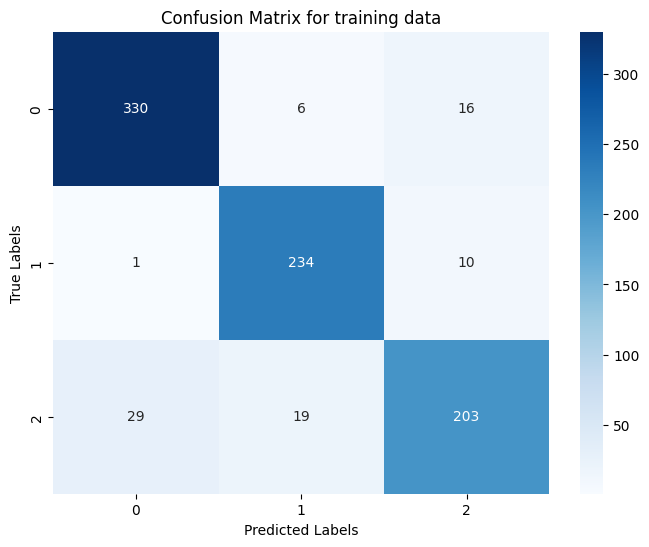

In [52]:
from sklearn.metrics import confusion_matrix

confusionm = confusion_matrix(y_train, y_train_pred)


plt.figure(figsize=(8,6))
sns.heatmap(confusionm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for training data')
plt.show()

# Further feature selection using feature importances
One of the most significant hyperparameters used was ccp_alpha. As mentioned earlier, this hyperparameter removes redundant nodes from the decision tree, leading to a smaller but more generalisable tree which has been seen through the performance results. Once this had been applied, the feature importances were investigated to assess whether the initial technical metrics were a good choice when attempting to classify player positioning.

The feature importance analysis reveals that the decision tree model primarily classifies players based on their spatial behaviour on the pitch, rather than purely attacking output. Metrics such as touches in the defensive third, tackles in the midfield third, and passes into the final third emerged as the most influential features. 

This indicates that the model distinguishes roles by identifying where players operate and how they contribute to transitions between defence, midfield, and attack. On the other hand, features which indicated a player’s technical ability when shooting and dribbling the ball were completely disregarded suggesting that positioning and ball movement patterns are more critical to accurate role classification. 

This relates back to both the existing literature from M. Kempe et al (2018) and points made earlier suggesting that movement off the ball correlates directly to more key passes and assists per 90 and how a player’s contribution to the team as a whole is more important than technical traits which are so heavily focussed on by modern scouting methods. Although the technical traits selected were centred around efficiency and high technical abilities, the results suggest that spatial behaviour is the best indicator for classifying the position of a player and how advanced player metrics which indicate high levels of technical ability should be used as the next step to compare players based on the specific needs of the club. 

In [53]:
clf.feature_importances_

array([0.        , 0.        , 0.        , 0.03219282, 0.01040247,
       0.        , 0.        , 0.        , 0.03955945, 0.02620901,
       0.01944392, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.07218084, 0.        , 0.76499873, 0.02146599,
       0.01354675])

In [54]:
X.columns

Index(['SoT', 'G/SoT', 'SCA', 'ScaPassLive', 'PasAss', 'ToSuc', 'AerWon',
       'PasTotPrgDist', 'Pas3rd', 'PasProg', 'Recov', 'CarPrgDist', 'CPA',
       'TklDri', 'TklDriPast', 'TklDef3rd', 'TklMid3rd', 'TklAtt3rd',
       'TouDef3rd', 'TouMid3rd', 'TouAtt3rd'],
      dtype='object')

In [55]:
features = pd.DataFrame(clf.feature_importances_, index = X.columns)

In [56]:
features.head(25)

,0
SoT,0.000000
G/SoT,0.000000
SCA,0.000000
ScaPassLive,0.032193
PasAss,0.010402
ToSuc,0.000000
AerWon,0.000000
PasTotPrgDist,0.000000
Pas3rd,0.039559
PasProg,0.026209
